#### 上节课的爬虫 复习

In [ ]:
import requests
from html import unescape

# 目标：提取出所有的 HTML 标签和描述，放入一个 Python dictionary 数据结构。

# 第一步：获取网页的完整源码

resp = requests.get("https://www.w3school.com.cn/tags/index.asp")
html = resp.text

# 第二步：找到合适的特征字符串，进行逐步切割

# 特征字符串 1：<table class="dataintable">

# 定位
feature_string_1_position = html.index("<table class=\"dataintable\">")
# 切割
html_step_1 = html[feature_string_1_position + len("<table class=\"dataintable\">"):]


# 特征字符串 2：</table>

# 定位 index
feature_string_2_position = html_step_1.index("</table>")  # 注意要用 html_step_1 而不是 html
# 切割 [start:end]
html_step_2 = html_step_1[:feature_string_2_position]

# "abcdef".index("cd") == 2
# "abcdef"[2:] == "cdef"
# "abcdef"[2 + len("cd"):] == "ef"

# 第三步：已经切出了有用的部分，进行 split 分割成小单元处理，每个小单元的结构是一样的

# 用 split 分割成 N+1 个部分，得到一个列表
all_cells = html_step_2.split("</tr>")
# 去掉表头
all_cells.pop(0)

# 用于储存结果的列表变量
result_list = []

# 在循环里面分析每个小单元
for cell in all_cells:
    try:
        # 储存小单元分析结果的字典变量
        cell_data = {}

        # 通过 print 发现前 23 个字符没用，丢掉
        useful_data = cell[23:]
        # 通过 print 发现网址结尾之后立马是一个双引号字符
        link = useful_data[0:useful_data.index('"')]
        # 储存
        cell_data["href"] = link

        # 通过 print 发现元素名部分从第一个双引号字符往后两个字符开始，到第一个 </td> 结束
        # 定位+切割一步完成
        element_name = useful_data[useful_data.index('"') + 2 : useful_data.index('</td>')]
        # 删除两端空白符避免干扰（strip()），删除可能存在的 &nbsp; 后缀避免干扰，删除一定存在的 </a> 后缀 （这些都没用）
        element_name = element_name.strip().removesuffix("&nbsp;").removesuffix("</a>")
        # 反转义，&lt; --> 小于号， &gt; --> 大于号
        element_name = unescape(element_name)
        # 储存
        cell_data["name"] = element_name

        # 通过 print 发现 元素用途从 useful_data 里的第一个 <td> 开始，先切一刀
        explanation = useful_data[useful_data.index("<td>") + len("<td>"):]
        # 通过 print 发现 元素用途到 explanation 里的第一个 </td> 结束，再切一刀
        explanation = explanation[:explanation.index("</td>")]
        # 储存
        cell_data["usage"] = explanation

        # 把当前 cell 的结果存进全局的结果列表里面
        result_list.append(cell_data)
    except:
        continue

# 遍历结果列表，打印
for info in result_list:
    print("标签：", info["name"])
    print("用途：", info["usage"])
    print("说明链接：", "https://www.w3school.com.cn{}".format(info["href"]))
    print()

for i in [0, 1, 0, 1, 0, 1]:
    try:
        print("new round", i)
        3/i
    except:
        print("error")
        continue
print("done")

```html
<div>
    <p>key1: value1</p>
    <p>key2: value2</p>
    <p>key3: value3</p>
    <p>key4: value4</p>
    <p>key5: value5</p>
    <p>key6: value6</p>
</div>
```

#### 使用正则表达式代替子串定位

正则表达式使用单个字符串来描述、匹配、替换一系列匹配某个句法规则的字符串。在很多语言中，正则语言字面量可以被放置在两个斜杠中间的部分。例如，/abc/ 表示内容为 abc 的正则表达式。

最初的正则表达式出现于理论计算机科学的自动控制理论和形式化语言理论中。正则表达式对应于乔姆斯基层级的类型 - 3 文法（Chomsky Type-3，等价于 Finite Automaton），但少数编程语言或其相关库（例如 PCRE、C#）中实现的正则表达式的表达能力是乔姆斯基层级中类型 - 3 文法的超集。

通常来讲，正则表达式无法完成很大规模的匹配任务。例如，单个正则表达式无法匹配所有合法的 HTML 代码，这是因为 HTML 在 Parsing 层面属于 Contex-Free Grammar（假如不考虑元素的 id 必须 unique 等限制），对应 Chomsky Type-2 文法。根据定义，Chomsky Type-2 文法是 Chomsky Type-3（有限自动机/正则语言/正则表达式）的超集，因此正则表达式无法匹配所有的 HTML 代码。

没看懂？没关系 这很正常，因为这完全是大学的专业课内容。我们接下来用人话把正则表达式讲一遍

##### 1 Atom 原子

Atom 表示正则中的最小不可分割单位。通常而言，正则表达式的 Atom 为单个字符：

1. 普通字符，例如 a b c 0 1 2 汉 字 等。
2. 如果要输入有特殊含义的符号，可能需要经过反斜杠转义：\(，\[ 等。
3. 如果要通过特殊符号来表示特殊的含义，同样需要经过转义：\n，\r，\t等。

本质上，它们都是在表示单个字符。正则表达式的最小匹配粒度也是单个字符。

##### 2 Character Classes 字符类

Character classes match a character from a specific set. There are a number of predefined character classes and you can also define your own sets.

2.1 Character Set 字符集

Syntax: `[ABC]`

Match: A or B or C

2.2 Negated Set 字符补集

Syntax: `[^ABC]`

Match: 任何不是 A 且不是 B 且不是 C 的字符

2.3 Range 字符范围

Syntax: `[A-D]` `[0-9]`

Match: A or B or C or D, 0 到 9 总共十个数字

2.4 Predefined Character Set 预定义的字符集

- \w word，匹配所有 alphanumberic 和 underscore，等价于 [A-Za-z0-9_]。
- \d numeric，等价于 [0-9]。
- \s whitespaces，匹配 \t、空格、\n 等空白符。
- . dot，匹配非 line break 的任意字符。等价于 [^\r\n]。

以及它们的补集（记忆方式：预定义的字符，更换成大写形式）

- \W  [^A-Za-z0-9_]
- \D  [^0-9]
- \S
- [\r\n]


以上内容可以组合使用。

- 例：[A-Za-z.\.\d] 匹配 A-Z 或 a-z 或 [^\r\n] 或英文句号或 0-9。不过，. 也就是 [^\r\n] 其实包含了剩下的几个 character set，因此本例中的正则表达式的匹配范围和 . 相同。
- 例：[\s\S] 可以匹配任意字符。实际上，[\d\D]、[\w\W] 也可以，但一般约定俗成用于匹配任意字符的还是 [\s\S]。

##### 3 Group 组

Groups allow you to combine a sequence of tokens to operate on them together.

3.1 Capturing Group 捕获组

Syntax: `(AB)`

"abcdef"   "cd" --> "CD"
"abCDef"

Match: AB

##### 4 Quantifiers 量词

Cindy Lu
Jeffrey Pan

12345678A123  [0-9A-Z]+?

- 重复一次或多次 +  --> [A-Za-z]+ *[A-Za-z]+
- 重复零次或多次 *  --> \d*
- 重复零次或一次 ?  --> \d?
  - 注意，? 出现在其它量词后时，还有「启用非贪婪匹配」的作用。正则表达式的量词默认为贪婪匹配，也就是尽可能匹配最多字符。
    - 重复一次或多次，但希望在使得整个正则表达式匹配成功的前提下尽量少匹配：+?
    - 重复零次或多次，但希望在使得整个正则表达式匹配成功的前提下尽量少匹配：*?
- 重复指定次数 {数字}   -->  \d{10} \d{10,12}
- 重复一定范围内的次数 {下界,上界}（两侧均包含）。如果上界省略，则表示上界为无穷大。换言之，\d{1,} 等价于 \d+。
- 替代 |。例如 `A|B` 等价于 `[AB]`。
  - 区别：你无法在 [] 内部使用 Group 和 Reference。然而如果采用 X|Y 形式，那么就可以使用 Group 和 Reference 了。

##### 5 Anchors 定位点

- 行首：^
- 行尾：$
- 词的边缘：\b
- 不在词的边缘：\B

"abcdef" "cd" --> 可以匹配
"abcdef" "^cd" --> 不能匹配
"cdef"   "^cd" --> 可以匹配
"abcd"   "cd$" --> 可以匹配

\b 和 \B 在处理「前面有空格、后面没有空格」这种匹配需求的时候非常好用。

正则表达式可视化：

https://c.runoob.com/front-end/7625/#!flags=&re=
https://regex-vis.com/

```python
import re   # Regular Expression 正则表达式

text = "要被搜索的文本"
print(re.findall("正则表达式", text))
```

### Beautiful Soup 4

#### 安装

In [5]:
! python3 -m pip install beautifulsoup4


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


#### 使用

基础用法

In [39]:
import bs4, requests

html = """<html><body><a href="/test">Goto test</a><div class="button button-primary c d e" id="test test">text1</div><div class="b">text2</div><p><a><div>inner div</div></a></p><div class="c">text3</div><div class="d"><p>p inside div</p></div><div class="e">text5</div><p>p1</p></body></html>
"""

soup = bs4.BeautifulSoup(html)
div_list = soup.find_all("div")

# my_div = div_list[0]
# print(my_div.get("class"))
# print(my_div.get("id"))

# a元素 = soup.find("a")  # find("x"): 找到页面上的第一个 x 元素
# print(a元素.get("href"))

source_code = """
<html>
<body>
  <p class="link2">Content</p>
  <a class="link" id="test1" href="https://www.baidu.com">Goto Baidu 1</a>
  <div>
    <a class="link link2 link3" id="test2" href="https://www.baidu.com">Goto Baidu 2</a>
  </div>
</body>
</html>
"""

soup = bs4.BeautifulSoup(source_code)
# a元素 = soup.find("a")
a元素 = soup.find_all("a")[0]
print(a元素.get("id"))

# id="x" --> #x id 名字前面加 #
# div 元素名直接写
# class="y" --> .y class 名字前面加点
#   class="a b c" --> .a.b.c / .a.c / .a.b / .b.c
# 父元素的 selector 和子元素的 selector 中间加空格，连接成一个完整 selector

print(soup.select("body div a#test2.link.link2.link3"))
print(soup.select("#test2"))
print(soup.select(".link2"))

test1
[<a class="link link2 link3" href="https://www.baidu.com" id="test2">Goto Baidu 2</a>]
[<a class="link link2 link3" href="https://www.baidu.com" id="test2">Goto Baidu 2</a>]
[<p class="link2">Content</p>, <a class="link link2 link3" href="https://www.baidu.com" id="test2">Goto Baidu 2</a>]


常用方法

- find_all - 标签名 找所有
- find - 标签名 只找第一次出现
- element.get("attribute")

解析文档结构：BeautifulSoup4提供了一些方法和属性来解析文档的结构。一些常用的属性包括soup.title（获取文档的标题）、soup.head（获取文档的头部）、soup.body（获取文档的主体）等。还可以使用find和find_all方法来查找特定的元素或标签。

遍历文档树：BeautifulSoup4提供了多种方法来遍历文档树，以查找和处理特定的标签和内容。其中一种常用的方法是使用标签名称来查找元素，例如soup.find_all('a')会返回文档中所有的`<a>`标签。还可以使用CSS选择器、正则表达式等方式来定位元素。

提取数据：一旦你找到了特定的元素或标签，你可以使用BeautifulSoup4提供的方法和属性来提取其中的数据。例如，使用element.text可以获取元素的文本内容，`element['attribute']`可以获取元素的属性值等。

速查表： https://www.crummy.com/software/BeautifulSoup/bs4/doc.zh/

示例：

<a id="x" class="link1 link2" href="/tag" style="" whatever="aha">text</a>

a#x.link1.link2[href="/tag"][style=""][whatever="aha"][id="x"]

In [42]:
import bs4, requests

source_code = """
<html>
<body>
  <p class="link2">Content</p>
  <a class="link" id="test1" href="https://www.baidu.com">Goto Baidu 1</a>
  <div>
    <a class="link link2 link3" id="test2" href="https://www.baidu.com">Goto Baidu 2</a>
  </div>
</body>
</html>
"""

soup = bs4.BeautifulSoup(source_code)
# a元素 = soup.find("a")
# a元素 = soup.find_all("a")[0]
# a元素 = soup.select('a[href="https://www.baidu.com"]#test1')
a元素 = soup.select('a[href="https://www.baidu.com"][id="test1"]')
print(a元素)

[<a class="link" href="https://www.baidu.com" id="test1">Goto Baidu 1</a>]


在BeautifulSoup4中，你可以使用CSS选择器来查找和提取HTML文档中的元素。下面是一些使用CSS选择器的示例：

标签选择器：使用标签名称来选择元素。例如，要选择所有的`<a>`标签，可以使用soup.select('a')。

class 选择器：使用类名来选择具有特定类的元素。类名前面加上点号`.`。例如，要选择所有具有类名为my-class的元素，可以使用`soup.select('.my-class')`。

ID选择器：使用元素的ID来选择特定的元素。ID名前面加上井号`#`。例如，要选择具有ID为my-id的元素，可以使用soup.select('#my-id')。

属性选择器：使用元素的属性来选择元素。方括号`[]`内可以指定属性名和属性值。例如，要选择所有具有href属性的`<a>`标签，可以使用`soup.select('a[href]')`。

后代选择器：使用空格来选择元素的后代元素。例如，要选择`<div>`元素内部的所有`<a>`标签，可以使用`soup.select('div a')`。

子元素选择器：使用大于号>来选择元素的直接子元素。例如，要选择`<div>`元素的直接子元素中的所有`<p>`标签，可以使用`soup.select('div > p')`。

群组选择器：使用逗号,将多个选择器组合在一起，选择多个元素。例如，要选择所有`<p>`标签和`<a>`标签，可以使用`soup.select('p, a')`。

In [57]:
import bs4, requests

source_code = """
<html>
<body>
  <p>
    <div style="color: red;">
      <a>表头</a>
    </div>
  </p>

  <p>
    <a>表身体的数据</a>
  </p>
</body>
</html>
"""

soup = bs4.BeautifulSoup(source_code)
a元素列表1 = soup.select('p a')
a元素列表2 = soup.select('p > a')
a元素列表3 = soup.select('p > a, p a')  # 取并集
print(a元素列表1)
print(a元素列表2)
print(a元素列表3)



source_code = """
<html>
<body>
  <p class="whatever">1</p>
  <p>2</p>
  <p class="hey">1</p>
</body>
</html>
"""

soup = bs4.BeautifulSoup(source_code)
p元素列表 = soup.select('p[class]')
print(p元素列表)


source_code = """
<html>
<body>
  <p class="whatever">1</p>
  <p><div></div></p>
  <p class="hey">1</p>
</body>
</html>
"""

soup = bs4.BeautifulSoup(source_code)
p元素列表1 = soup.select('p:last-child')
p元素列表2 = soup.select('p :last-child')
print(p元素列表1)
print(p元素列表2)
p元素列表3 = soup.select('p:nth-child(2)')
p元素列表4 = soup.select('p:nth-last-child(2)')
print(p元素列表3)
print(p元素列表4)

p = soup.select(".whatever")[0]
print(p.get_text())

# 先定位 再提取
# index find split | [start:end] removeprefix removesuffix strip
# 字符串操作的复杂度在于构思出合适的字符串切割、提取的步骤和方式
# soup.select      | element.get_text()
# selector 的复杂度在于编写 selector 本身

[<a>表头</a>, <a>表身体的数据</a>]
[<a>表身体的数据</a>]
[<a>表头</a>, <a>表身体的数据</a>]
[<p class="whatever">1</p>, <p class="hey">1</p>]
[<p class="hey">1</p>]
[<div></div>]
[<p><div></div></p>]
[<p><div></div></p>]
1


#### 高级 CSS Selector 语法

速查表： https://www.freecodecamp.org/news/css-selectors-cheat-sheet/

我们会参考 https://dev.to/dawnind/css3-selectors-cheat-sheet-6dk 这个完整的 CSS Selector 表，来展开这部分内容。

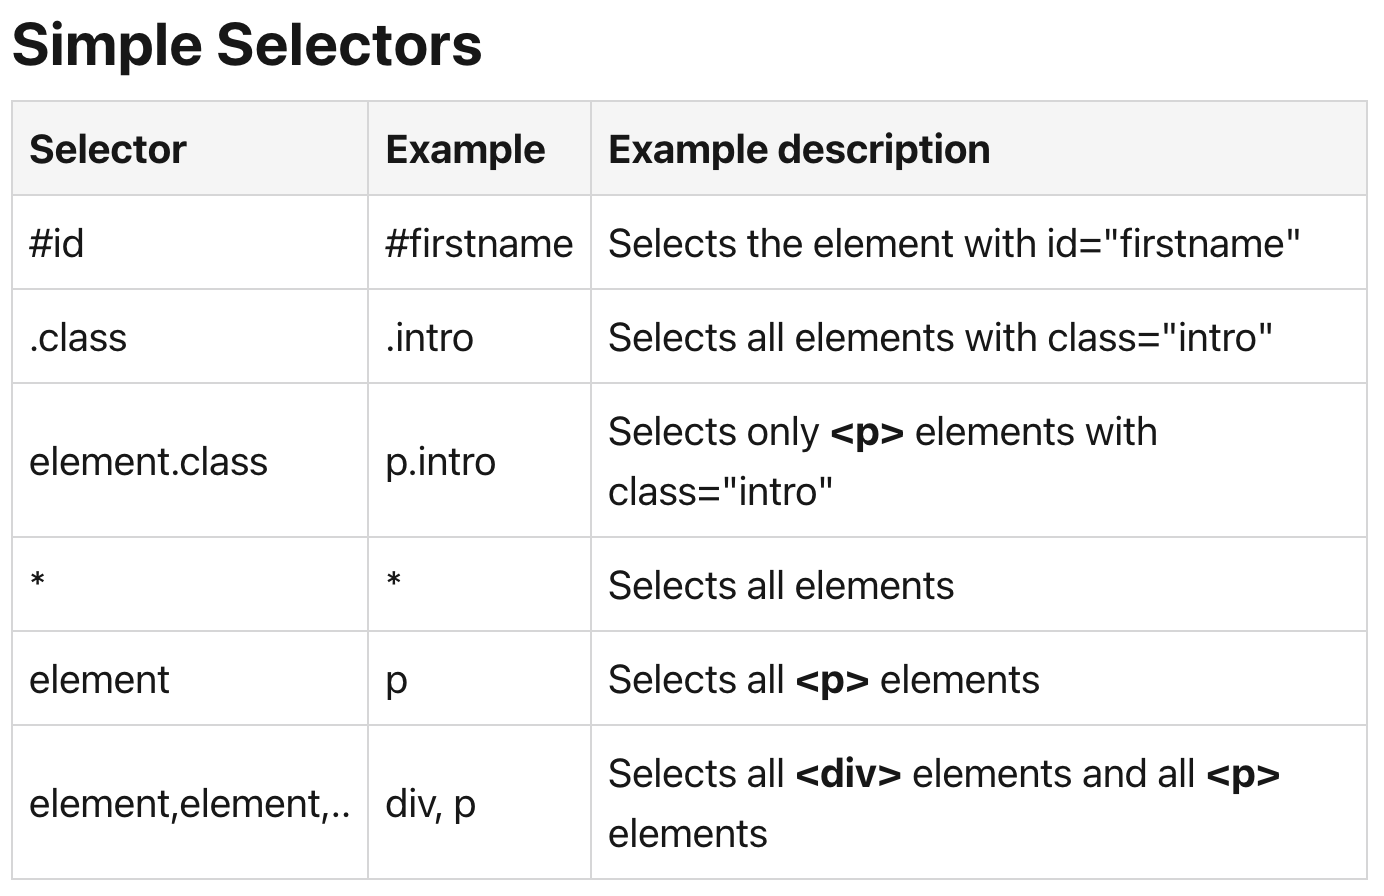

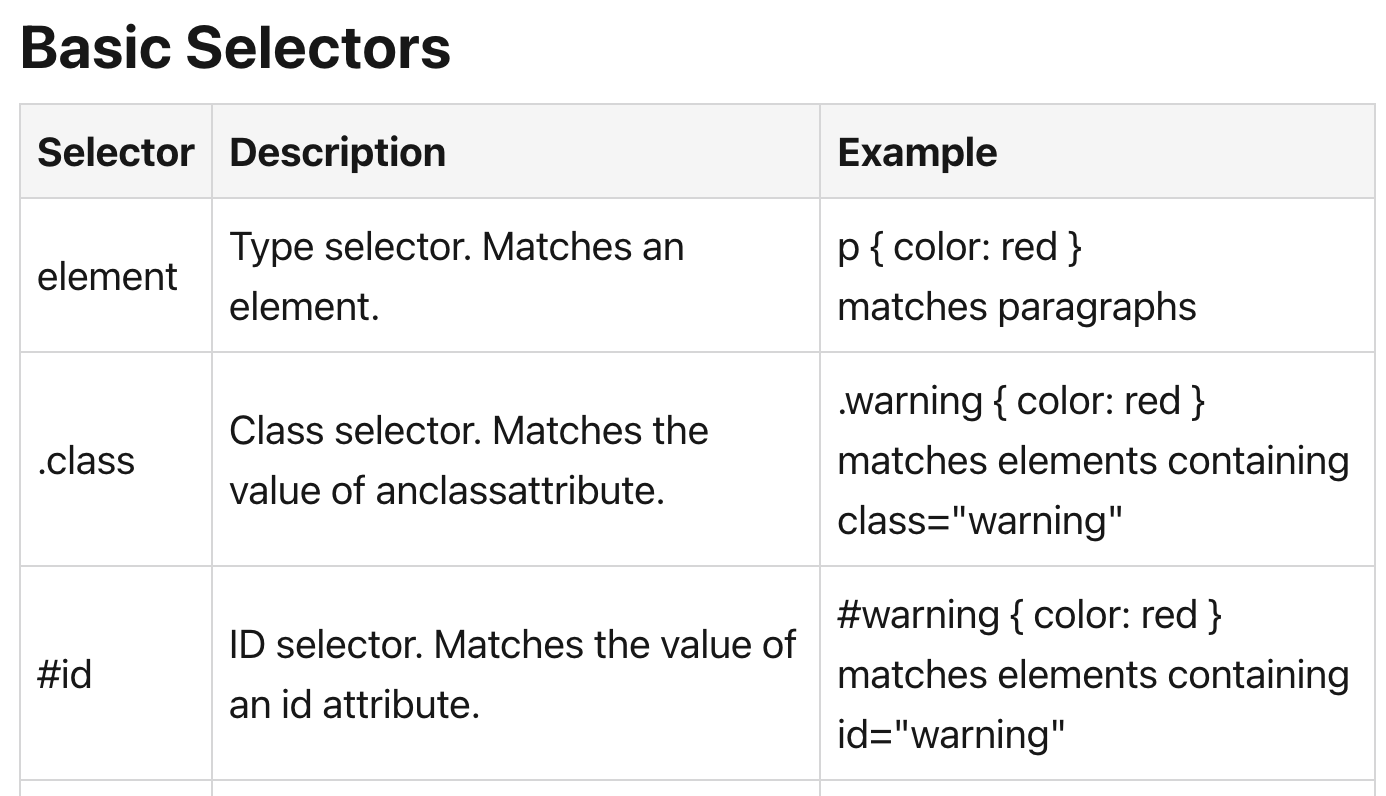

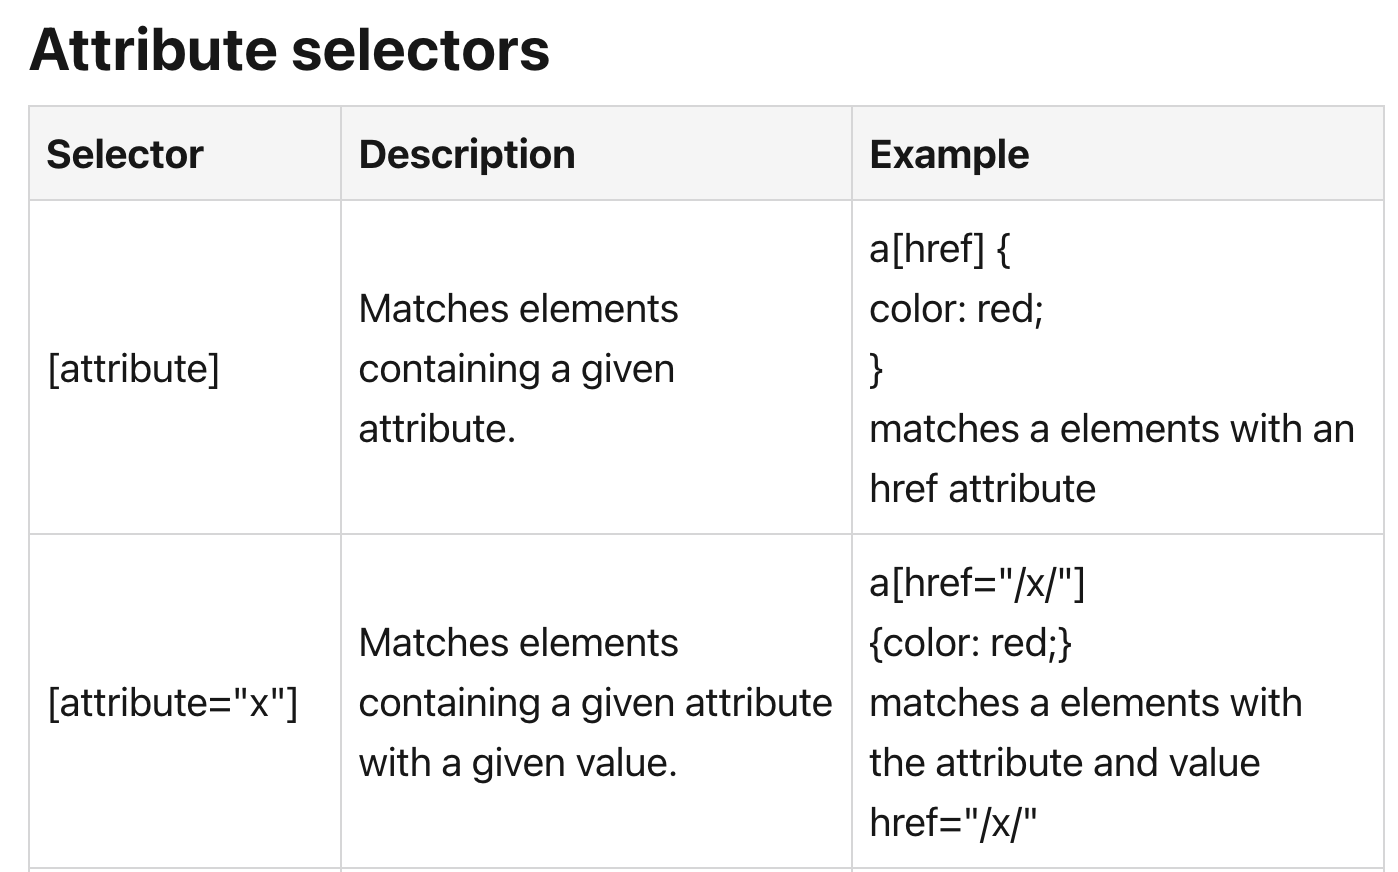

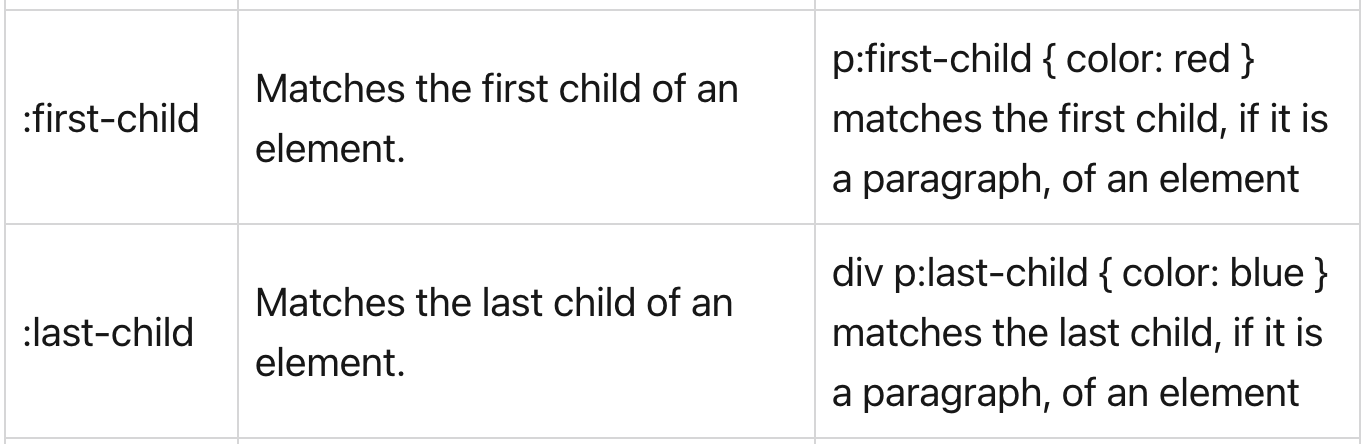

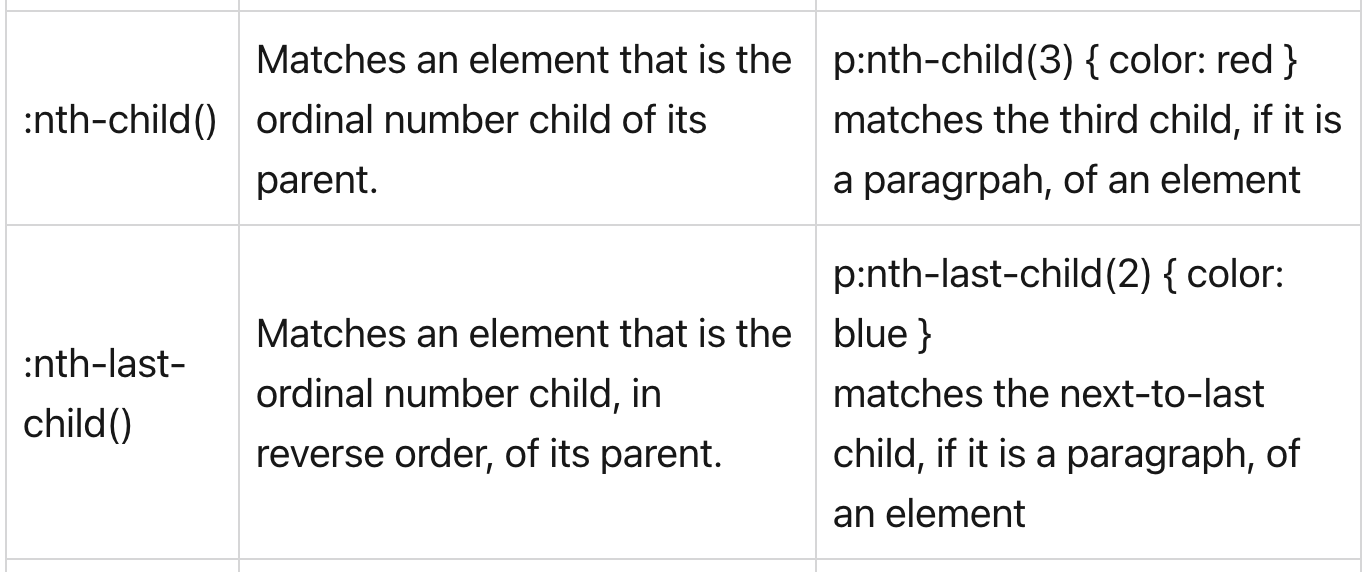

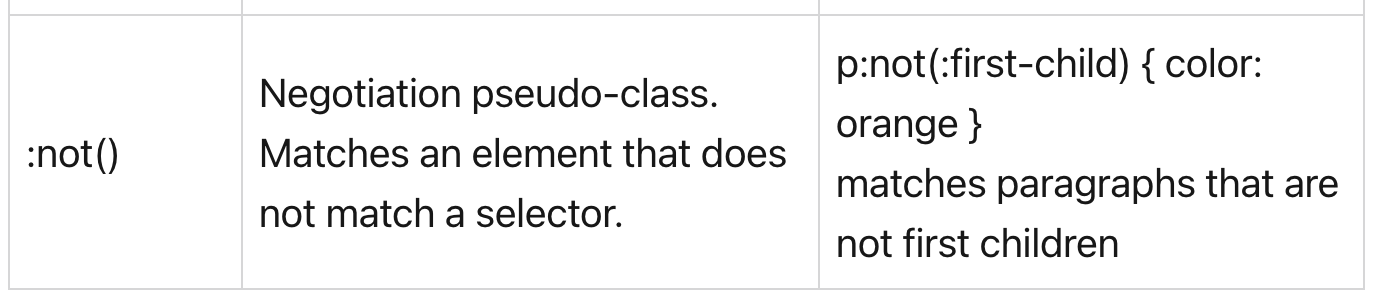

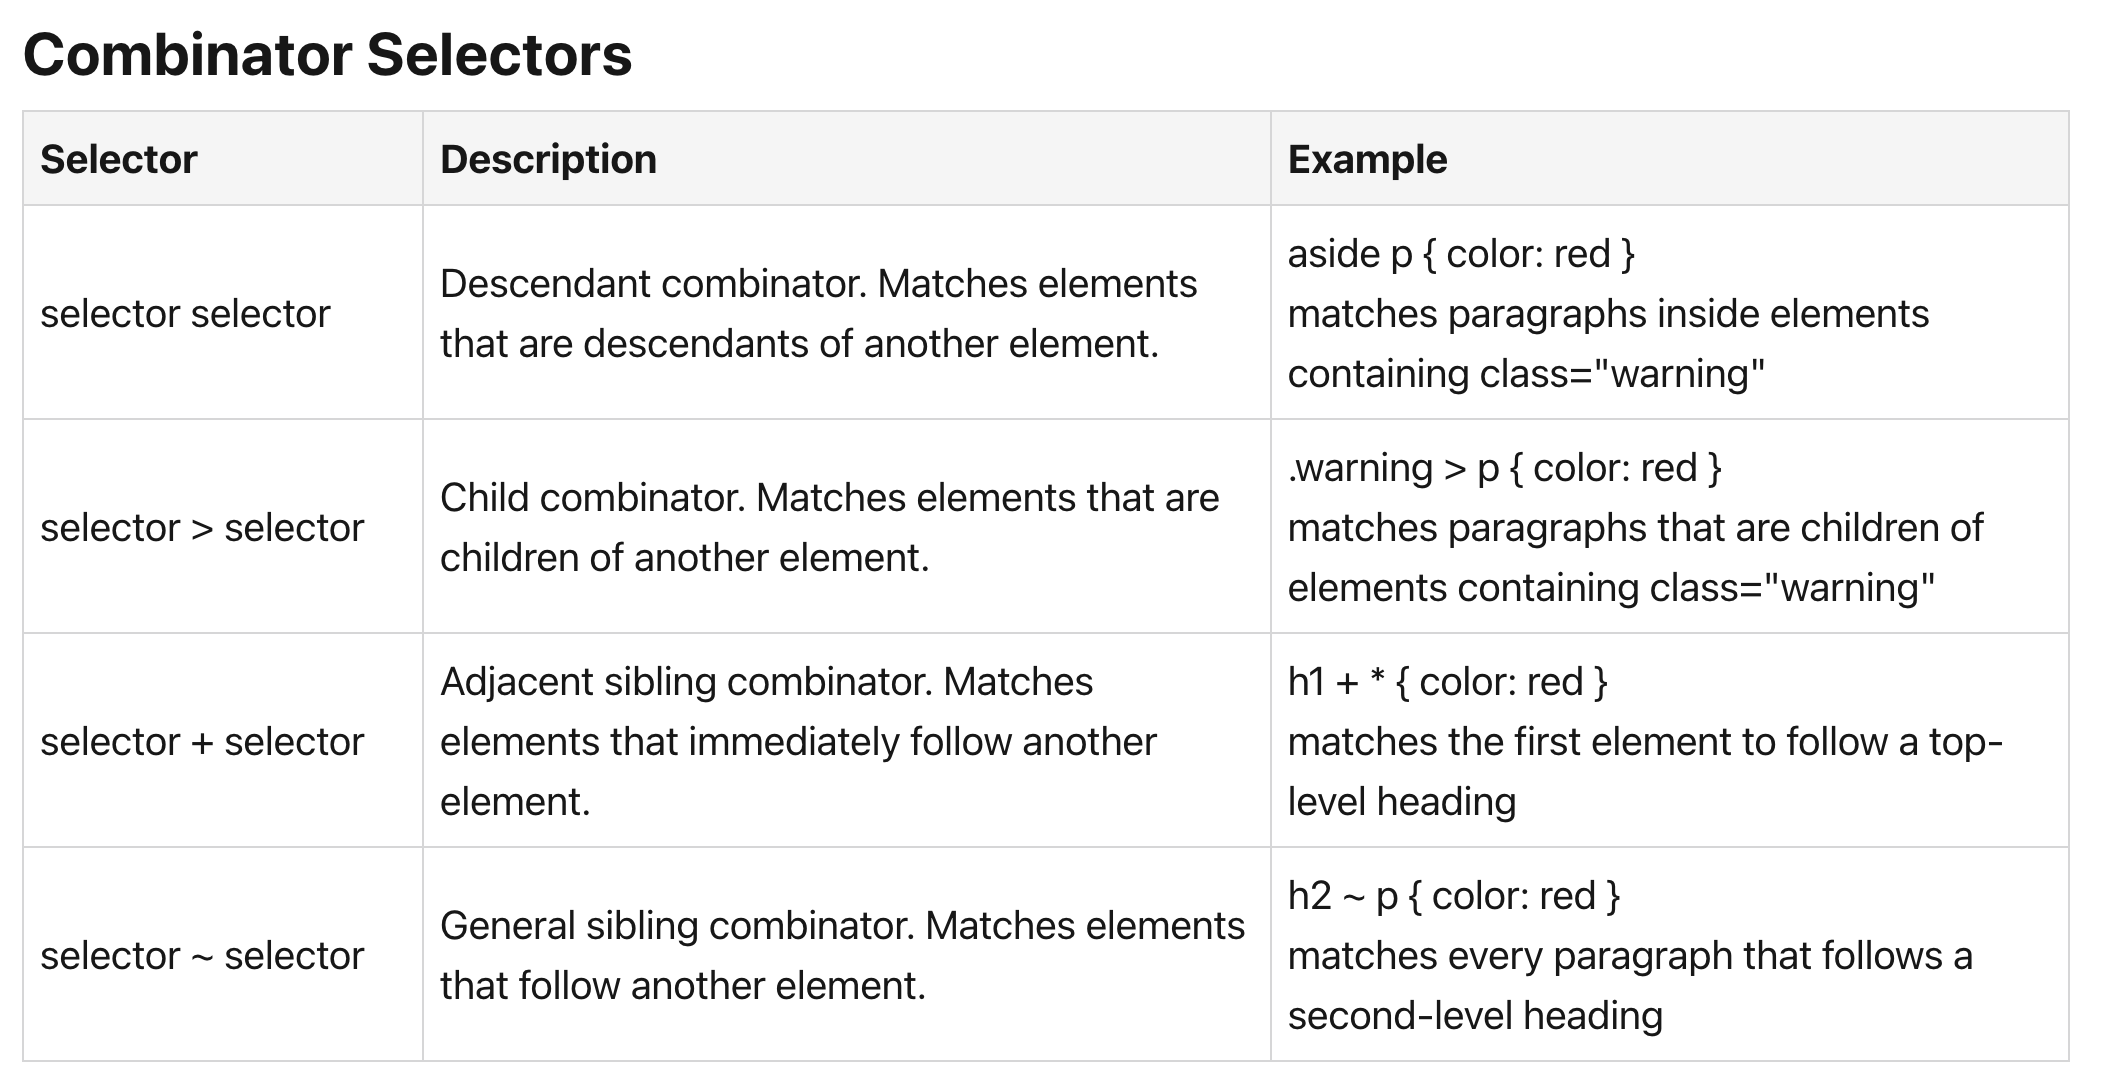

group selector: `div,p`

#### 用 Selector 代替字符串操作，重写上节课最后的小爬虫

实操

In [59]:
from time import sleep

print("Before sleep")
sleep(3)
print("After sleep")

Before sleep
After sleep
